# *BASECODE 작성*

* 가상환경 activate 후 lightgbm 설치
* conda install -c conda-forge lightgbm

In [73]:
import warnings
warnings.filterwarnings('ignore')
import glob
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
import random
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import log_loss

## 0. **데이터 로드**
* 훈련에 필요없는 index 컬럼 삭제
#### 변수
* train : `train.csv`
* test : `test.csv`

In [74]:
# 데이터 불러오기
train = pd.read_csv('./train.csv')
train = train.drop(['index'], axis=1)

test = pd.read_csv('./test.csv')
test = test.drop(['index'], axis=1)

submit = pd.read_csv('./sample_submission.csv')

### 데이터 전처리
http://www.dodomira.com/2016/10/20/how_to_eda/ 

링크 참고 

## 1. **데이터 셋 확인**

* 이전 EDA 코드 돌려봤기에 코드를 직접 합치지는 않았음

In [75]:
train.info()
test.info()
display(train.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gender         26457 non-null  object 
 1   car            26457 non-null  object 
 2   reality        26457 non-null  object 
 3   child_num      26457 non-null  int64  
 4   income_total   26457 non-null  float64
 5   income_type    26457 non-null  object 
 6   edu_type       26457 non-null  object 
 7   family_type    26457 non-null  object 
 8   house_type     26457 non-null  object 
 9   DAYS_BIRTH     26457 non-null  int64  
 10  DAYS_EMPLOYED  26457 non-null  int64  
 11  FLAG_MOBIL     26457 non-null  int64  
 12  work_phone     26457 non-null  int64  
 13  phone          26457 non-null  int64  
 14  email          26457 non-null  int64  
 15  occyp_type     18286 non-null  object 
 16  family_size    26457 non-null  float64
 17  begin_month    26457 non-null  float64
 18  credit

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0


In [76]:
# 각 유형 갯수 확인
count_type = [0, 0, 0] # object, int64, float64
for col in train.columns:
    if train[col].dtype == 'object':
        count_type[0] += 1
    elif train[col].dtype == 'int64':
        count_type[1] += 1
    elif train[col].dtype == 'float64':
        count_type[2] += 1
display(count_type)

[8, 7, 4]

#### object 8개, int64 7개 , float64 4개 있음.
-------------------------

## 2. **결측치 처리**
* 결측치는 직업 유형에만 존재함 -> 'unfilled'로 대체함. 
* 향후 '직업 유형의 결측치를 어떻게 해결할 것 인가' 고민이 필요함.

In [77]:
test['occyp_type'].count

<bound method Series.count of 0                  NaN
1           Core staff
2             Laborers
3              Drivers
4             Managers
             ...      
9995       Accountants
9996          Laborers
9997    Medicine staff
9998               NaN
9999          Laborers
Name: occyp_type, Length: 10000, dtype: object>

In [78]:
test['occyp_type'].isnull().sum()

3152

In [79]:
# 결측치 확인
print('훈련데이터 결측치 합 \n', train.isnull().sum())
print('테스트데이터 결측치 합 \n', test.isnull().sum())

훈련데이터 결측치 합 
 gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type       8171
family_size         0
begin_month         0
credit              0
dtype: int64
테스트데이터 결측치 합 
 gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type       3152
family_size         0
begin_month         0
dtype: int64


In [80]:
# 결측치 처리
print()
train['occyp_type'].fillna('unfilled', inplace=True) # 직업 유형 경우, 결측치가 많아서 따로 'unfilled' 라고 채움
test['occyp_type'].fillna('unfilled', inplace=True)
train.fillna('NAN', inplace=True) 
test.fillna('NAN', inplace=True)

# 확인
print('훈련데이터 결측치 합 \n', train.isnull().sum())
print('테스트데이터 결측치 합 \n', test.isnull().sum())


훈련데이터 결측치 합 
 gender           0
car              0
reality          0
child_num        0
income_total     0
income_type      0
edu_type         0
family_type      0
house_type       0
DAYS_BIRTH       0
DAYS_EMPLOYED    0
FLAG_MOBIL       0
work_phone       0
phone            0
email            0
occyp_type       0
family_size      0
begin_month      0
credit           0
dtype: int64
테스트데이터 결측치 합 
 gender           0
car              0
reality          0
child_num        0
income_total     0
income_type      0
edu_type         0
family_type      0
house_type       0
DAYS_BIRTH       0
DAYS_EMPLOYED    0
FLAG_MOBIL       0
work_phone       0
phone            0
email            0
occyp_type       0
family_size      0
begin_month      0
dtype: int64


## 3. **이상치 처리**
* 정수형, 실수형 데이터에서 이상치 찾아보고, 그에 맞게 처리하자.

In [81]:
display(len(train.columns))
display((train.columns))

19

Index(['gender', 'car', 'reality', 'child_num', 'income_total', 'income_type',
       'edu_type', 'family_type', 'house_type', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'FLAG_MOBIL', 'work_phone', 'phone', 'email', 'occyp_type',
       'family_size', 'begin_month', 'credit'],
      dtype='object')

### **3-1. 각 컬럼 데이터 변환 and 이상치 처리**
* 정수/실수형 데이터를 가진 10개 컬럼 중 휴대전화/직장전화/가정용전화/이메일 보유여부는 이상치 없음. (1아니면 0이니깐)
* 이 외에 6개 컬럼들 하나씩 살펴보기
 * 6개: 자녀 수, 가족 규모, 연간 소득, 출생일, 업무 시작일, 신용카드 발급 월 
 * 또한 분석하기 용이하게 데이터 변경 (ex) 부호 변환 or 일 수를 나이로)

#### 1) 자녀 수
* 6명 이상의 자녀를 가진 사람은 5명으로 변경 -> 이유: test set에서 자녀의 수 max가 5 이기 때문. 

In [82]:
print('train childnum unique:', train['child_num'].unique())

train childnum unique: [ 0  1  2  3  4  5 14 19  7]


In [83]:
print('test childnum unique:', test['child_num'].unique())

test childnum unique: [0 1 2 3 5 4]


childnum unique: [0 1 2 3 4 5]


<AxesSubplot:xlabel='child_num'>

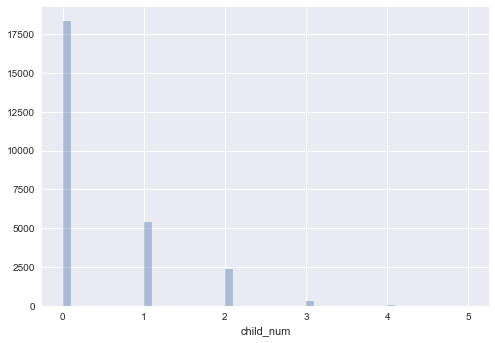

In [84]:
# 아이가 6명 이상인 데이터는 5로 변경
train.loc[train['child_num'] >= 6,'child_num']=5
print('childnum unique:', train['child_num'].unique())
sns.distplot(train['child_num'], kde=False, label='child_num')

#### 2) 가족 규모
* 1의 이유와 같이 최대 아이 숫자를 5로 했기 때문에 가족 규모의 최댓값도 7로 변경함

In [85]:
print('train familysize unique:', train['family_size'].unique())

train familysize unique: [ 2.  3.  4.  1.  5.  6.  7. 15. 20.  9.]


In [86]:
print('test familysize unique:', test['family_size'].unique())

test familysize unique: [2 1 3 4 5 7 6]


In [87]:
train.loc[train['family_size'] >= 8,'family_size']=7

train familysize unique: [2. 3. 4. 1. 5. 6. 7.]


<AxesSubplot:xlabel='family_size'>

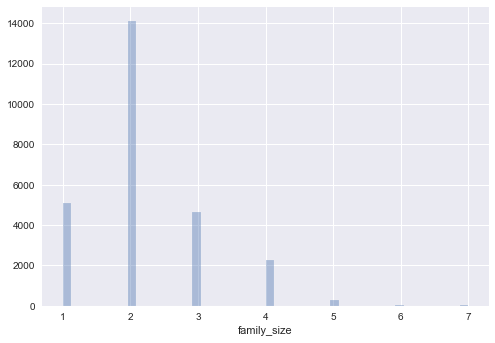

In [88]:
print('train familysize unique:', train['family_size'].unique())
sns.distplot(train['family_size'], kde=False, label='family_size')

#### 3) 연간 소득
* 테스트 데이터에서도 박스플롯 밖의 값이 많이 있기에 박스플롯 밖의 값 제거 안하기로 결정

Text(0.5, 1.0, 'test Boxplot of income_total')

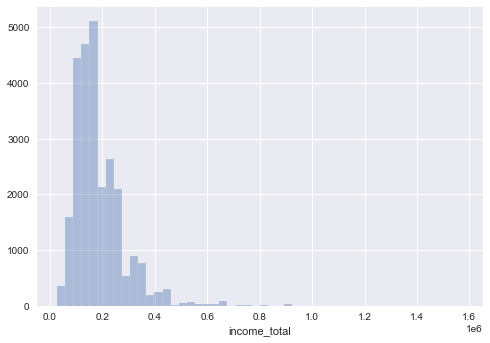

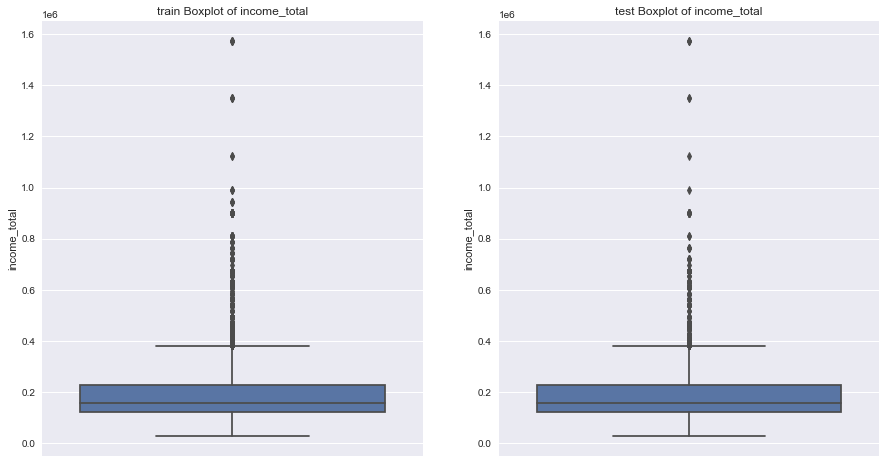

In [89]:
sns.distplot(train['income_total'], kde=False, label='income_total')
fig, ax = plt.subplots(1, 2, figsize=(15,8))
sns.boxplot(y=train["income_total"],data=train, ax=ax[0])
ax[0].set_title("train Boxplot of income_total")

sns.boxplot(y=test["income_total"],data=test, ax=ax[1])
ax[1].set_title("test Boxplot of income_total")

#### 4) 출생일 -> 나이
* 양수 변환 후 나이로 변환
* 정수형으로 변환

In [90]:
def days_to_age(x):
    return (x*-1)/365

# train
train['DAYS_BIRTH'] = train['DAYS_BIRTH'].apply(days_to_age)
train['DAYS_BIRTH'] = train['DAYS_BIRTH'].astype({'DAYS_BIRTH':'int'})
display(train['DAYS_BIRTH'])

# test
test['DAYS_BIRTH'] = test['DAYS_BIRTH'].apply(days_to_age)
test['DAYS_BIRTH'] = test['DAYS_BIRTH'].astype({'DAYS_BIRTH':'int'})
display(test['DAYS_BIRTH'])

0        38
1        31
2        52
3        41
4        41
         ..
26452    33
26453    41
26454    27
26455    27
26456    53
Name: DAYS_BIRTH, Length: 26457, dtype: int32

0       60
1       51
2       43
3       52
4       48
        ..
9995    50
9996    29
9997    57
9998    45
9999    25
Name: DAYS_BIRTH, Length: 10000, dtype: int32

#### 5) 업무시작일 -> 업무 연차
* 양수 변환 후 연차로 변환
    * 단, 365243은 0연차로 변환
    * 135일 일한 사람과 0연차를 구분하기 위해서 0연차를 제외하고 모두 +1 해줌
* 정수형으로 변환

In [91]:
def days_to_year(x):
    if x==365243 :
        return 0
    return (x*-1)/365+1

# train
train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'].apply(days_to_year)
train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'].astype({'DAYS_EMPLOYED':'int'})
display(train['DAYS_EMPLOYED'])

# test
test['DAYS_EMPLOYED'] = test['DAYS_EMPLOYED'].apply(days_to_year)
test['DAYS_EMPLOYED'] = test['DAYS_EMPLOYED'].astype({'DAYS_EMPLOYED':'int'})
display(test['DAYS_EMPLOYED'])

0        13
1         5
2        13
3         6
4         6
         ..
26452     6
26453     7
26454     6
26455     1
26456     3
Name: DAYS_EMPLOYED, Length: 26457, dtype: int32

0        0
1       24
2        1
3        7
4       26
        ..
9995    15
9996     4
9997    39
9998     3
9999     1
Name: DAYS_EMPLOYED, Length: 10000, dtype: int32

#### 6) 신용카드 발급 월

* 양수로 변환

In [92]:
def minus(x):
    return x * -1

# train
train['begin_month'] = train['begin_month'].apply(minus)
display(train['begin_month'])

# test
test['begin_month'] = test['begin_month'].apply(minus)
display(test['begin_month'])

0         6.0
1         5.0
2        22.0
3        37.0
4        26.0
         ... 
26452     2.0
26453    47.0
26454    25.0
26455    59.0
26456     9.0
Name: begin_month, Length: 26457, dtype: float64

0       60
1       36
2       40
3       41
4        8
        ..
9995    19
9996    34
9997    55
9998    33
9999    11
Name: begin_month, Length: 10000, dtype: int64

#### 7) 박스 플롯을 통한 이상치 확인
* 박스플롯

In [93]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gender         26457 non-null  object 
 1   car            26457 non-null  object 
 2   reality        26457 non-null  object 
 3   child_num      26457 non-null  int64  
 4   income_total   26457 non-null  float64
 5   income_type    26457 non-null  object 
 6   edu_type       26457 non-null  object 
 7   family_type    26457 non-null  object 
 8   house_type     26457 non-null  object 
 9   DAYS_BIRTH     26457 non-null  int32  
 10  DAYS_EMPLOYED  26457 non-null  int32  
 11  FLAG_MOBIL     26457 non-null  int64  
 12  work_phone     26457 non-null  int64  
 13  phone          26457 non-null  int64  
 14  email          26457 non-null  int64  
 15  occyp_type     26457 non-null  object 
 16  family_size    26457 non-null  float64
 17  begin_month    26457 non-null  float64
 18  credit

* 1) 신용카드 발급 월
* 2) 업무 연차
* 3) 나이
* 4) 연간 수입
 * 4개 컬럼에 대해 박스플롯 그려보기

Text(0.5, 1.0, "Boxplot of test's begin_month")

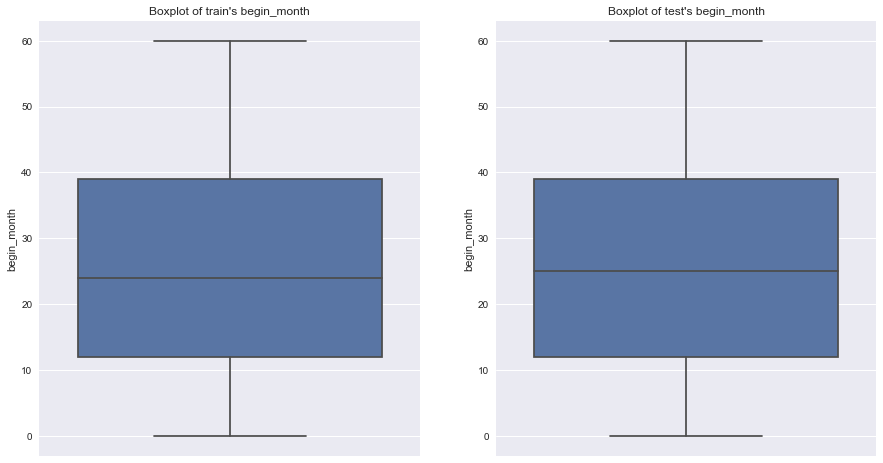

In [94]:
# 신용카드 발급 월의 박스플롯
fig, ax = plt.subplots(1, 2, figsize=(15,8))

sns.boxplot(y=train["begin_month"],data=train, ax=ax[0])
ax[0].set_title("Boxplot of train's begin_month")

sns.boxplot(y=test["begin_month"],data=test, ax=ax[1])
ax[1].set_title("Boxplot of test's begin_month")

Text(0.5, 1.0, "Boxplot of test's DAYS_BIRTH")

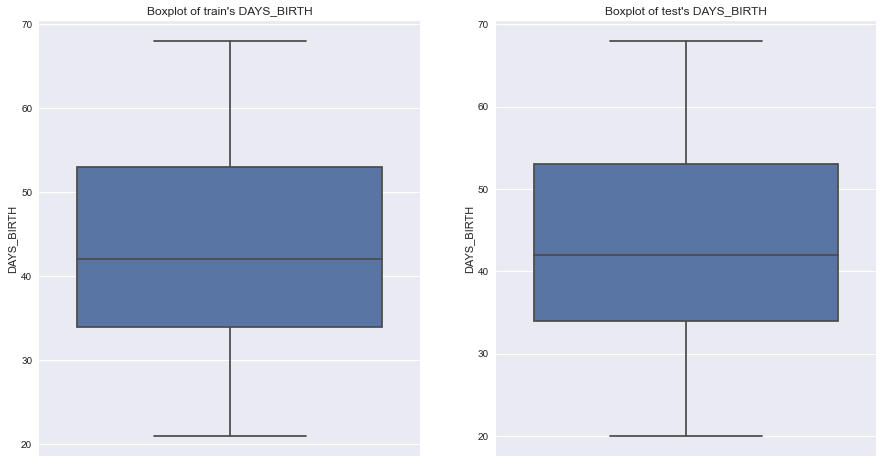

In [95]:
# 나이에 대한 박스플롯
fig, ax = plt.subplots(1, 2, figsize=(15,8))

sns.boxplot(y=train["DAYS_BIRTH"],data=train, ax=ax[0])
ax[0].set_title("Boxplot of train's DAYS_BIRTH")

sns.boxplot(y=test["DAYS_BIRTH"],data=test, ax=ax[1])
ax[1].set_title("Boxplot of test's DAYS_BIRTH")

Text(0.5, 1.0, "Boxplot of test's income_total")

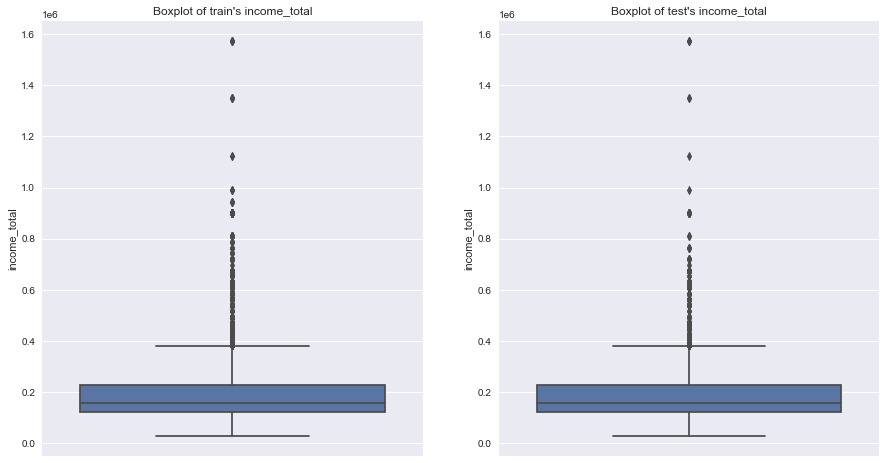

In [96]:
# 연간 수입에 대한 박스플롯
fig, ax = plt.subplots(1, 2, figsize=(15,8))

sns.boxplot(y=train["income_total"],data=train, ax=ax[0])
ax[0].set_title("Boxplot of train's income_total")

sns.boxplot(y=test["income_total"],data=test, ax=ax[1])
ax[1].set_title("Boxplot of test's income_total")

Text(0.5, 1.0, "Boxplot of test's DAYS_EMPLOYED")

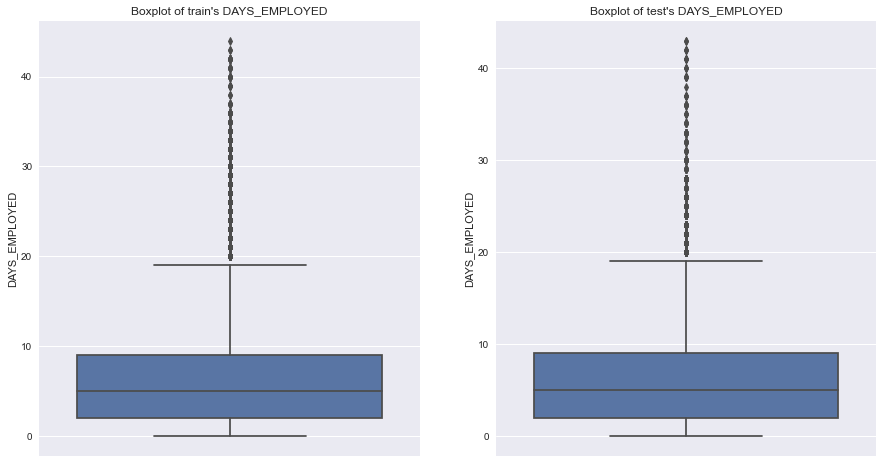

In [97]:
# 업무 연차에 대한 박스플롯
fig, ax = plt.subplots(1, 2, figsize=(15,8))

sns.boxplot(y=train["DAYS_EMPLOYED"],data=train, ax=ax[0])
ax[0].set_title("Boxplot of train's DAYS_EMPLOYED")

sns.boxplot(y=test["DAYS_EMPLOYED"],data=test, ax=ax[1])
ax[1].set_title("Boxplot of test's DAYS_EMPLOYED")

Text(0.5, 1.0, 'Boxplot of family_size')

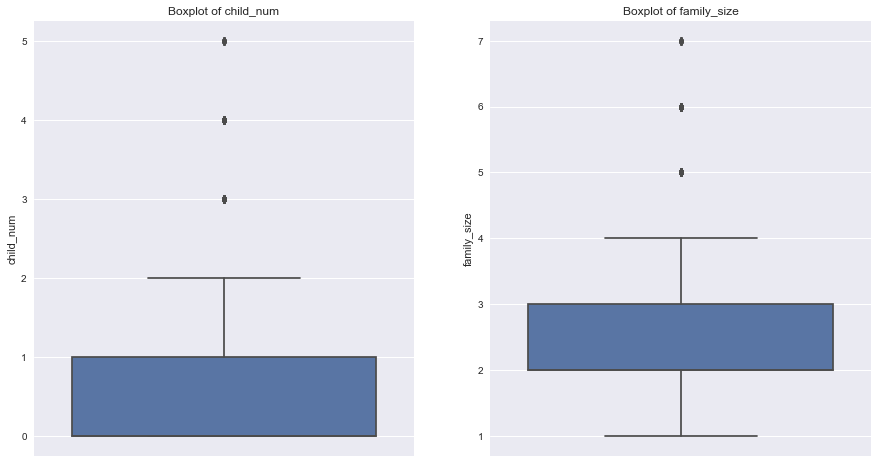

In [98]:
# child_num, family_size
fig, ax = plt.subplots(1, 2, figsize=(15,8))

sns.boxplot(y=train["child_num"],data=train, ax=ax[0])
ax[0].set_title("Boxplot of child_num")

sns.boxplot(y=train["family_size"],data=train, ax=ax[1])
ax[1].set_title("Boxplot of family_size")

#### 8) 상관관계
* 범주형과 수치형 상관관계 확인 - https://dodonam.tistory.com/217

<AxesSubplot:>

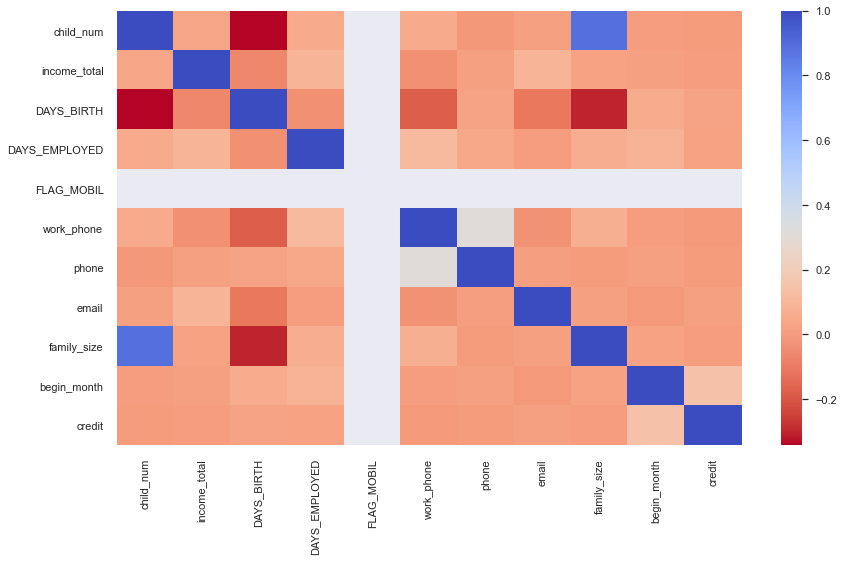

In [99]:
#상관관계를 확인
sns.set(rc={'figure.figsize':(14,8)})
corr = train.corr()
sns.heatmap(corr, cmap='coolwarm_r')

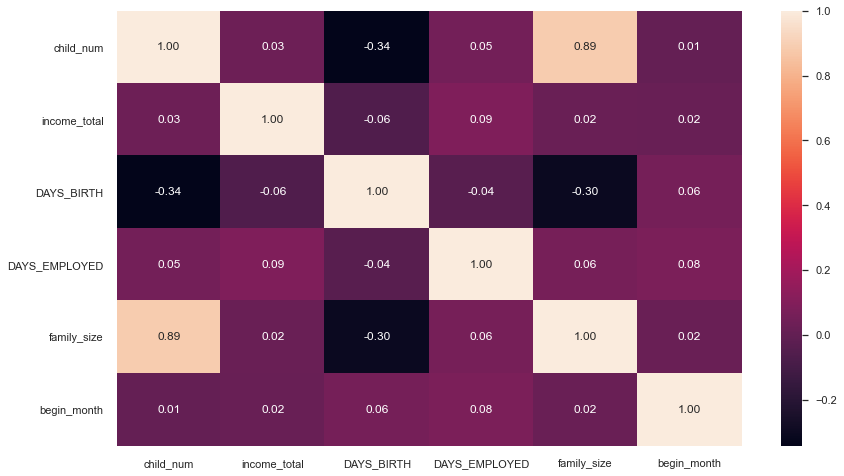

In [100]:
# 다중 공선성 확인
list_numeric = ["child_num", "income_total", "DAYS_BIRTH", "DAYS_EMPLOYED", "family_size", "begin_month"]
sns.heatmap(train[list_numeric].corr(), annot = True, fmt = ".2f")
plt.show()

In [101]:
#상관관계 수치로 확인
# 종속변수('Class')와의 상관관계
Corr = train.corr()
IF = Corr['credit'].sort_values().to_frame()
display(IF.head(5))
print(IF)

,credit
work_phone,-0.003134
child_num,0.002601
phone,0.003452
family_size,0.007195
income_total,0.008555


                 credit
work_phone    -0.003134
child_num      0.002601
phone          0.003452
family_size    0.007195
income_total   0.008555
email          0.014812
DAYS_EMPLOYED  0.023476
DAYS_BIRTH     0.025059
begin_month    0.147477
credit         1.000000
FLAG_MOBIL          NaN


* 신용도와 가장 상관관계가 높은 컬럼은 "begin_month" 이나 0.147에 불과함

#### 9) 회귀분석 그래프

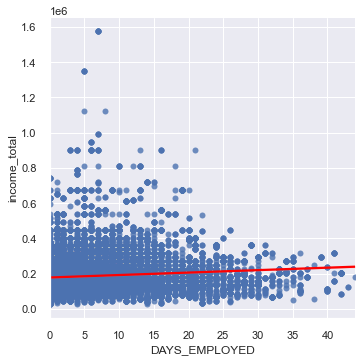

In [102]:
# 9-1. 연차와 연간 소득의 회귀분석 그래프
# 연차가 낮은데 소득이 굉장히 많은 경우는 제거해도 좋을 듯
sns.lmplot(x="DAYS_EMPLOYED", y="income_total", data=train, line_kws={'color':"red"})

## 4. **Feature Engineering** - 여기에 정규화 포함시켜야 할듯요!

* 수치형 컬럼은 기존 데이터 분포와 비슷하고, 어느정도 일정한 범위를 갖게 정규화해야함
* 각 컬럼마다 동일한 스케일러 적용할 필요는 없음. 
* [다른 스케일러 적용한 사례- 블로그](https://lsjsj92.tistory.com/555?category=853217)

### 4-1. 범주형 데이터 one-hot encoding, label encoding
* object (범주형)은 원핫인코딩 하기.
    * 단, occyp_type은 라벨 인코딩.
* 범주형 데이터를 가지는 변수 확인 (dtype가 object)
* gender(2), car(2), reality(2), income_type(5), edu_type(5), family_type(5), house_type(6), occyp_type(18)

In [103]:
# object 객체를 가지는 변수(열) 확인
object_col = []
for col in train.columns:
    if train[col].dtype == 'object' : # and col!='occyp_type': # 변수가 18개인 occyp_type만 제외
        object_col.append(col)
display(object_col)

['gender',
 'car',
 'reality',
 'income_type',
 'edu_type',
 'family_type',
 'house_type',
 'occyp_type']

In [104]:
print(train['occyp_type'].unique())
(len(train['occyp_type'].unique()))

['unfilled' 'Laborers' 'Managers' 'Sales staff' 'High skill tech staff'
 'Core staff' 'Drivers' 'Medicine staff' 'Accountants' 'Realty agents'
 'Security staff' 'Cleaning staff' 'Private service staff' 'Cooking staff'
 'Secretaries' 'HR staff' 'IT staff' 'Low-skill Laborers'
 'Waiters/barmen staff']


19

#### 4-1-1. train의 원핫인코딩, 라벨인코딩

In [105]:
# occyp_type을 제외한 모든 object객체 열을 onehot encoding

enc = OneHotEncoder()
enc.fit(train.loc[:,object_col])

train_onehot_df = pd.DataFrame(enc.transform(train.loc[:,object_col]).toarray(), 
             columns=enc.get_feature_names(object_col))
train.drop(object_col, axis=1, inplace=True)
train = pd.concat([train, train_onehot_df], axis=1)

In [106]:
# occyp_type을 label encoding

# label_encoder=preprocessing.LabelEncoder()
# train['occyp_type']=label_encoder.fit_transform(train['occyp_type'])

In [107]:
# 인코딩 확인

display(train.head(5))
print(train.columns)
train.info()

,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month,...,occyp_type_Low-skill Laborers,occyp_type_Managers,occyp_type_Medicine staff,occyp_type_Private service staff,occyp_type_Realty agents,occyp_type_Sales staff,occyp_type_Secretaries,occyp_type_Security staff,occyp_type_Waiters/barmen staff,occyp_type_unfilled
0,0,202500.0,38,13,1,0,0,0,2.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,247500.0,31,5,1,0,0,1,3.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,450000.0,52,13,1,0,1,0,2.0,22.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,202500.0,41,6,1,0,1,0,2.0,37.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0,157500.0,41,6,1,0,0,0,2.0,26.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Index(['child_num', 'income_total', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'FLAG_MOBIL', 'work_phone', 'phone', 'email', 'family_size',
       'begin_month', 'credit', 'gender_F', 'gender_M', 'car_N', 'car_Y',
       'reality_N', 'reality_Y', 'income_type_Commercial associate',
       'income_type_Pensioner', 'income_type_State servant',
       'income_type_Student', 'income_type_Working',
       'edu_type_Academic degree', 'edu_type_Higher education',
       'edu_type_Incomplete higher', 'edu_type_Lower secondary',
       'edu_type_Secondary / secondary special', 'family_type_Civil marriage',
       'family_type_Married', 'family_type_Separated',
       'family_type_Single / not married', 'family_type_Widow',
       'house_type_Co-op apartment', 'house_type_House / apartment',
       'house_type_Municipal apartment', 'house_type_Office apartment',
       'house_type_Rented apartment', 'house_type_With parents',
       'occyp_type_Accountants', 'occyp_type_Cleaning staff',
       'occyp

#### 4-1-2. test의 원핫인코딩, 라벨인코딩

In [108]:
# occyp_type을 제외한 모든 object객체 열을  onehot encoding
enc = OneHotEncoder()
enc.fit(test.loc[:,object_col])

test_onehot_df = pd.DataFrame(enc.transform(test.loc[:,object_col]).toarray(), 
             columns=enc.get_feature_names(object_col))
test.drop(object_col, axis=1, inplace=True)
test = pd.concat([test, test_onehot_df], axis=1)

In [109]:
# occyp_type을 label encoding

# label_encoder=preprocessing.LabelEncoder()
# test['occyp_type']=label_encoder.fit_transform(test['occyp_type'])

In [110]:
# 인코딩 확인

display(test.head(5))
print(test.columns)
test.info()

,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month,...,occyp_type_Low-skill Laborers,occyp_type_Managers,occyp_type_Medicine staff,occyp_type_Private service staff,occyp_type_Realty agents,occyp_type_Sales staff,occyp_type_Secretaries,occyp_type_Security staff,occyp_type_Waiters/barmen staff,occyp_type_unfilled
0,0,112500.0,60,0,1,0,1,0,2,60,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,135000.0,51,24,1,0,1,0,2,36,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,69372.0,43,1,1,1,1,0,2,40,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,112500.0,52,7,1,1,0,0,2,41,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,225000.0,48,26,1,1,0,0,2,8,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Index(['child_num', 'income_total', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'FLAG_MOBIL', 'work_phone', 'phone', 'email', 'family_size',
       'begin_month', 'gender_F', 'gender_M', 'car_N', 'car_Y', 'reality_N',
       'reality_Y', 'income_type_Commercial associate',
       'income_type_Pensioner', 'income_type_State servant',
       'income_type_Student', 'income_type_Working',
       'edu_type_Academic degree', 'edu_type_Higher education',
       'edu_type_Incomplete higher', 'edu_type_Lower secondary',
       'edu_type_Secondary / secondary special', 'family_type_Civil marriage',
       'family_type_Married', 'family_type_Separated',
       'family_type_Single / not married', 'family_type_Widow',
       'house_type_Co-op apartment', 'house_type_House / apartment',
       'house_type_Municipal apartment', 'house_type_Office apartment',
       'house_type_Rented apartment', 'house_type_With parents',
       'occyp_type_Accountants', 'occyp_type_Cleaning staff',
       'occyp_type_Cook

### 4-2. 데이터 정규화

#### 정규화 전 분포도
* 수치형 데이터만

<AxesSubplot:xlabel='begin_month', ylabel='Density'>

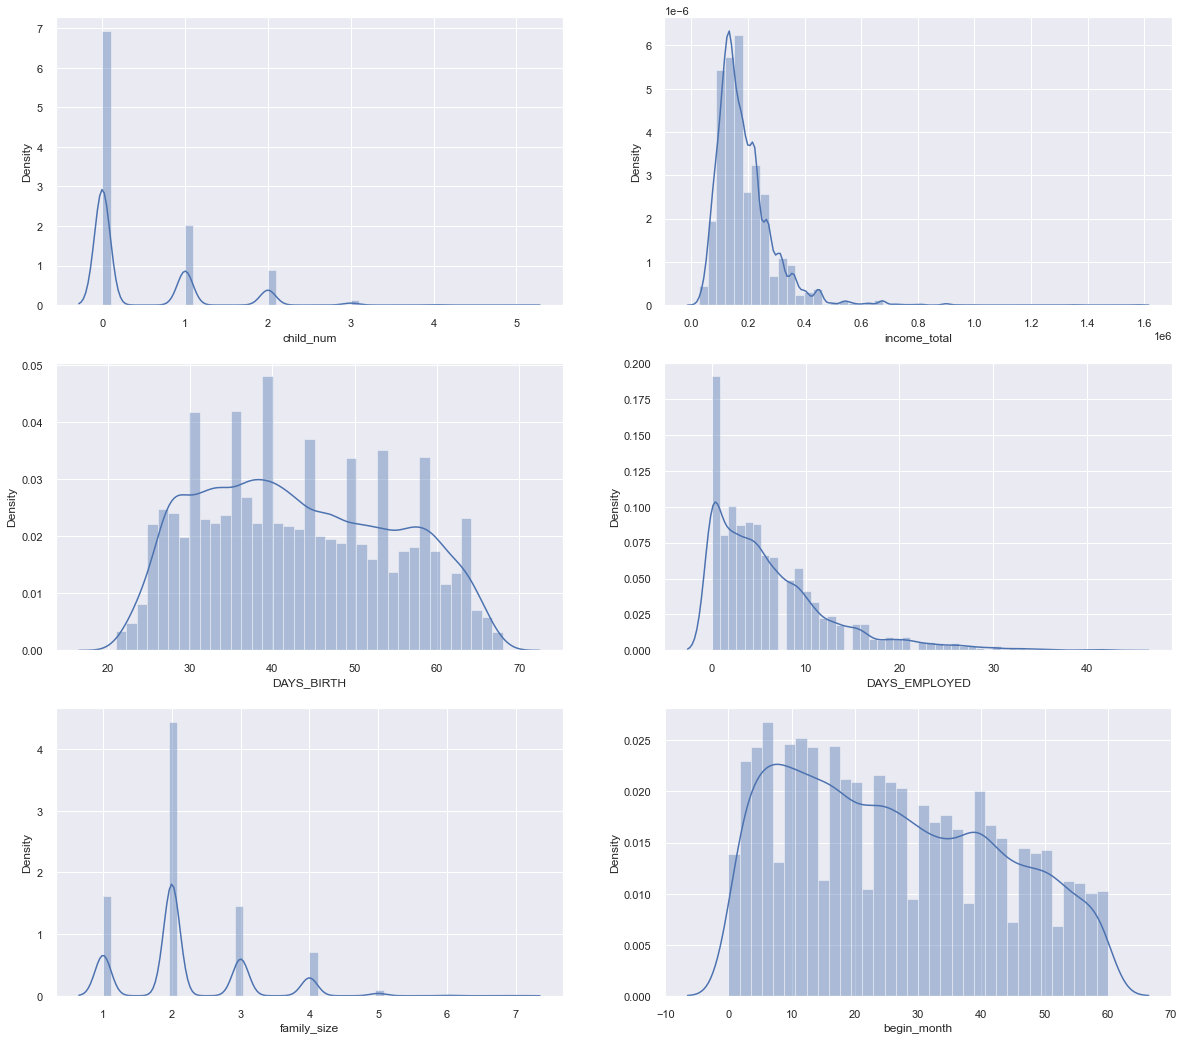

In [111]:
fig, ax = plt.subplots(3, 2, figsize=(20,18))

sns.distplot(train['child_num'], ax=ax[0][0])
sns.distplot(train['income_total'], ax=ax[0][1])

sns.distplot(train['DAYS_BIRTH'], ax=ax[1][0])
sns.distplot(train['DAYS_EMPLOYED'], ax=ax[1][1])

sns.distplot(train['family_size'], ax=ax[2][0])
sns.distplot(train['begin_month'], ax=ax[2][1])

#### 4-2-1. MinMaxScaler

In [112]:
from sklearn.preprocessing import MinMaxScaler

MinMaxScaler_data = train[train.columns.difference(['credit'])].copy()

minMaxScaler = MinMaxScaler()
print(minMaxScaler.fit(MinMaxScaler_data))
train_data_minMaxScaled = minMaxScaler.transform(MinMaxScaler_data)

# MinMaxScaler_data - MinMaxScaler적용한 데이터 프레임
index = 0
for col in MinMaxScaler_data.columns :
    MinMaxScaler_data[col] = train_data_minMaxScaled[:,index]
    index = index + 1
display(MinMaxScaler_data)

MinMaxScaler()


,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,begin_month,car_N,car_Y,child_num,edu_type_Academic degree,edu_type_Higher education,edu_type_Incomplete higher,...,occyp_type_Realty agents,occyp_type_Sales staff,occyp_type_Secretaries,occyp_type_Security staff,occyp_type_Waiters/barmen staff,occyp_type_unfilled,phone,reality_N,reality_Y,work_phone
0,0.361702,0.295455,0.0,0.100000,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.212766,0.113636,0.0,0.083333,1.0,0.0,0.2,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.659574,0.295455,0.0,0.366667,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.425532,0.136364,0.0,0.616667,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,0.425532,0.136364,0.0,0.433333,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,0.255319,0.136364,0.0,0.033333,1.0,0.0,0.4,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
26453,0.425532,0.159091,0.0,0.783333,1.0,0.0,0.2,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
26454,0.127660,0.136364,0.0,0.416667,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
26455,0.127660,0.022727,0.0,0.983333,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


<AxesSubplot:xlabel='begin_month', ylabel='Density'>

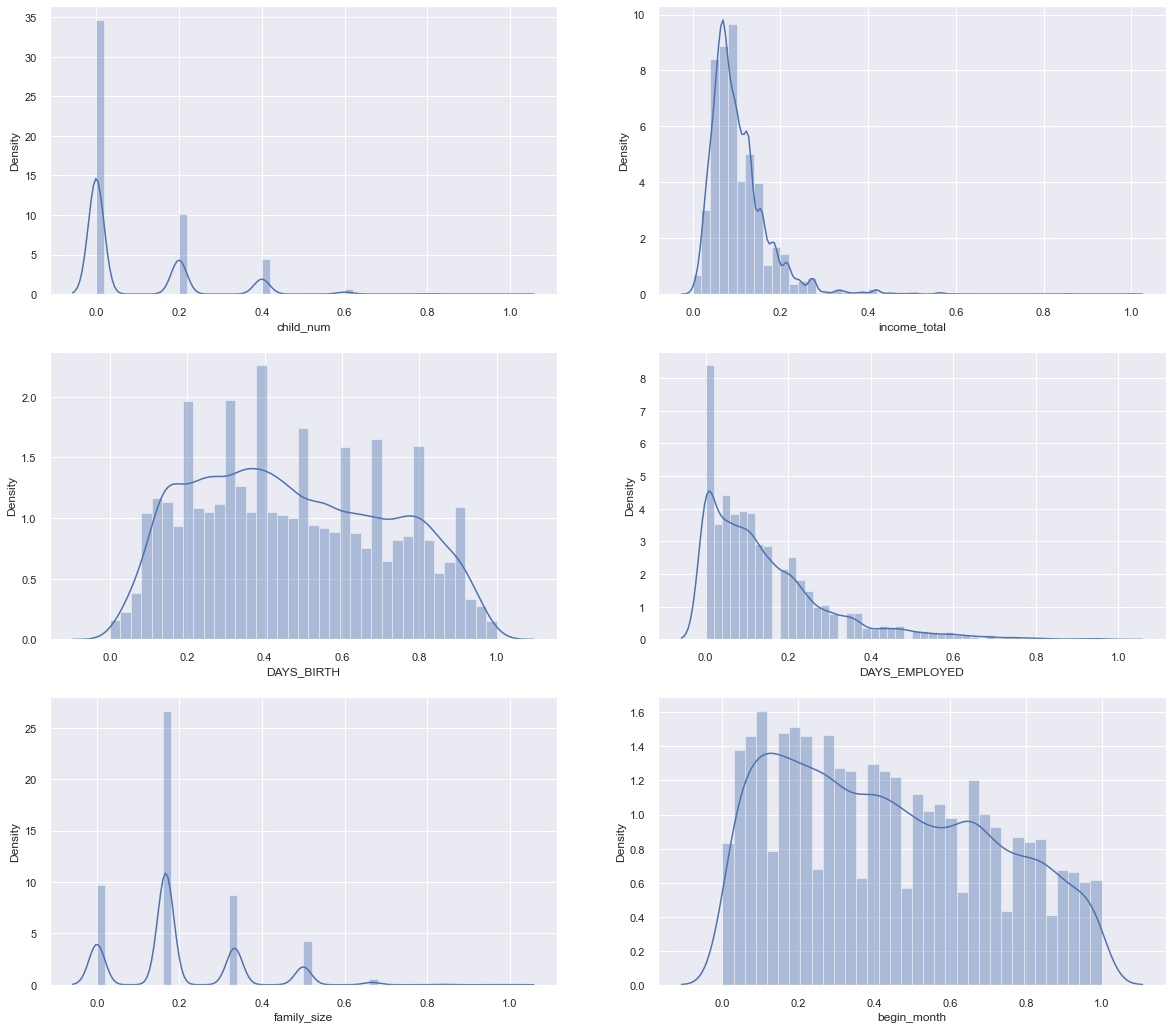

In [113]:
# MinMaxScaler 적용한 후 분포도 확인
fig, ax = plt.subplots(3, 2, figsize=(20,18))

sns.distplot(MinMaxScaler_data['child_num'], ax=ax[0][0])
sns.distplot(MinMaxScaler_data['income_total'], ax=ax[0][1])

sns.distplot(MinMaxScaler_data['DAYS_BIRTH'], ax=ax[1][0])
sns.distplot(MinMaxScaler_data['DAYS_EMPLOYED'], ax=ax[1][1])

sns.distplot(MinMaxScaler_data['family_size'], ax=ax[2][0])
sns.distplot(MinMaxScaler_data['begin_month'], ax=ax[2][1])

#### 4-2-2 MaxAbsScaler

In [114]:
from sklearn.preprocessing import MaxAbsScaler

MaxAbsScaler_data = train[train.columns.difference(['credit'])].copy()

maxAbsScaler = MaxAbsScaler()
print(maxAbsScaler.fit(MaxAbsScaler_data))
train_data_maxAbsScaled = maxAbsScaler.transform(MaxAbsScaler_data)

# MaxAbsScaler_data - MaxAbsScaler 적용한 데이터 프레임
index = 0
for col in MaxAbsScaler_data.columns :
    MaxAbsScaler_data[col] = train_data_maxAbsScaled[:,index]
    index = index + 1
display(MaxAbsScaler_data)

MaxAbsScaler()


,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,begin_month,car_N,car_Y,child_num,edu_type_Academic degree,edu_type_Higher education,edu_type_Incomplete higher,...,occyp_type_Realty agents,occyp_type_Sales staff,occyp_type_Secretaries,occyp_type_Security staff,occyp_type_Waiters/barmen staff,occyp_type_unfilled,phone,reality_N,reality_Y,work_phone
0,0.558824,0.295455,1.0,0.100000,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.455882,0.113636,1.0,0.083333,1.0,0.0,0.2,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.764706,0.295455,1.0,0.366667,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.602941,0.136364,1.0,0.616667,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,0.602941,0.136364,1.0,0.433333,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,0.485294,0.136364,1.0,0.033333,1.0,0.0,0.4,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
26453,0.602941,0.159091,1.0,0.783333,1.0,0.0,0.2,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
26454,0.397059,0.136364,1.0,0.416667,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
26455,0.397059,0.022727,1.0,0.983333,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,begin_month,car_N,car_Y,child_num,edu_type_Academic degree,edu_type_Higher education,edu_type_Incomplete higher,...,occyp_type_Realty agents,occyp_type_Sales staff,occyp_type_Secretaries,occyp_type_Security staff,occyp_type_Waiters/barmen staff,occyp_type_unfilled,phone,reality_N,reality_Y,work_phone
0,0.361702,0.295455,0.0,0.100000,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.212766,0.113636,0.0,0.083333,1.0,0.0,0.2,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.659574,0.295455,0.0,0.366667,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.425532,0.136364,0.0,0.616667,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,0.425532,0.136364,0.0,0.433333,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,0.255319,0.136364,0.0,0.033333,1.0,0.0,0.4,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
26453,0.425532,0.159091,0.0,0.783333,1.0,0.0,0.2,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
26454,0.127660,0.136364,0.0,0.416667,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
26455,0.127660,0.022727,0.0,0.983333,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


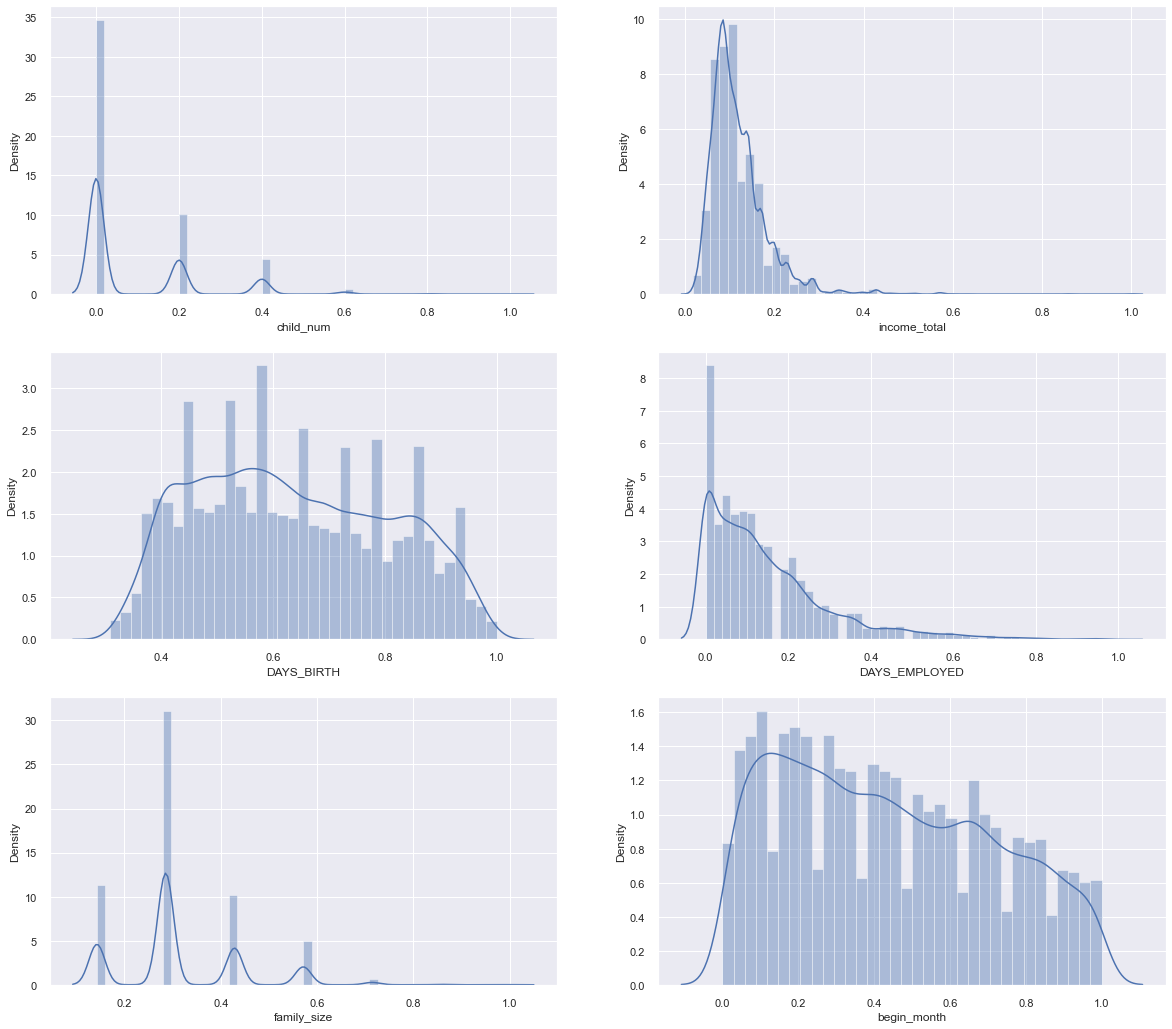

In [115]:
# MaxAbsScaler_data 적용한 후 분포도 확인
fig, ax = plt.subplots(3, 2, figsize=(20,18))

sns.distplot(MaxAbsScaler_data['child_num'], ax=ax[0][0])
sns.distplot(MaxAbsScaler_data['income_total'], ax=ax[0][1])

sns.distplot(MaxAbsScaler_data['DAYS_BIRTH'], ax=ax[1][0])
sns.distplot(MaxAbsScaler_data['DAYS_EMPLOYED'], ax=ax[1][1])

sns.distplot(MaxAbsScaler_data['family_size'], ax=ax[2][0])
sns.distplot(MaxAbsScaler_data['begin_month'], ax=ax[2][1])


MinMaxScaler_data


#### 4-2-3 StandardScaler

In [116]:
from sklearn.preprocessing import StandardScaler

StandardScaler_data = train[train.columns.difference(['credit'])].copy()

standardScaler = StandardScaler()
print(standardScaler.fit(StandardScaler_data))
train_data_standardScaled = standardScaler.transform(StandardScaler_data)

# StandardScaler_data - StandardScaler 적용한 데이터 프레임
index = 0
for col in StandardScaler_data.columns :
    StandardScaler_data[col] = train_data_standardScaled[:,index]
    index = index + 1
display(StandardScaler_data)

StandardScaler()


,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,begin_month,car_N,car_Y,child_num,edu_type_Academic degree,edu_type_Higher education,edu_type_Incomplete higher,...,occyp_type_Realty agents,occyp_type_Sales staff,occyp_type_Secretaries,occyp_type_Security staff,occyp_type_Waiters/barmen staff,occyp_type_unfilled,phone,reality_N,reality_Y,work_phone
0,-0.452819,0.996418,0.0,-1.215231,0.782463,-0.782463,-0.588681,-0.029497,1.641365,-0.200248,...,-0.048856,-0.325813,-0.060662,-0.127621,-0.068622,1.495966,-0.645705,1.437626,-1.437626,-0.538417
1,-1.060808,-0.219047,0.0,-1.275620,0.782463,-0.782463,0.790102,-0.029497,-0.609249,-0.200248,...,-0.048856,-0.325813,-0.060662,-0.127621,-0.068622,-0.668464,-0.645705,-0.695591,0.695591,-0.538417
2,0.763158,0.996418,0.0,-0.249003,-1.278015,1.278015,-0.588681,-0.029497,1.641365,-0.200248,...,-0.048856,-0.325813,-0.060662,-0.127621,-0.068622,-0.668464,1.548696,-0.695591,0.695591,-0.538417
3,-0.192253,-0.067114,0.0,0.656836,0.782463,-0.782463,-0.588681,-0.029497,-0.609249,-0.200248,...,-0.048856,3.069242,-0.060662,-0.127621,-0.068622,-0.668464,1.548696,-0.695591,0.695591,-0.538417
4,-0.192253,-0.067114,0.0,-0.007446,-1.278015,1.278015,-0.588681,-0.029497,1.641365,-0.200248,...,-0.048856,-0.325813,-0.060662,-0.127621,-0.068622,-0.668464,-0.645705,-0.695591,0.695591,-0.538417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,-0.887097,-0.067114,0.0,-1.456788,0.782463,-0.782463,2.168885,-0.029497,-0.609249,-0.200248,...,-0.048856,-0.325813,-0.060662,-0.127621,-0.068622,-0.668464,-0.645705,1.437626,-1.437626,-0.538417
26453,-0.192253,0.084819,0.0,1.260729,0.782463,-0.782463,0.790102,-0.029497,1.641365,-0.200248,...,-0.048856,-0.325813,-0.060662,-0.127621,-0.068622,1.495966,-0.645705,-0.695591,0.695591,-0.538417
26454,-1.408230,-0.067114,0.0,-0.067835,-1.278015,1.278015,-0.588681,-0.029497,-0.609249,-0.200248,...,-0.048856,-0.325813,-0.060662,-0.127621,-0.068622,-0.668464,-0.645705,1.437626,-1.437626,-0.538417
26455,-1.408230,-0.826780,0.0,1.985400,0.782463,-0.782463,-0.588681,-0.029497,-0.609249,4.993820,...,-0.048856,-0.325813,-0.060662,-0.127621,-0.068622,-0.668464,-0.645705,-0.695591,0.695591,-0.538417


<AxesSubplot:xlabel='begin_month', ylabel='Density'>

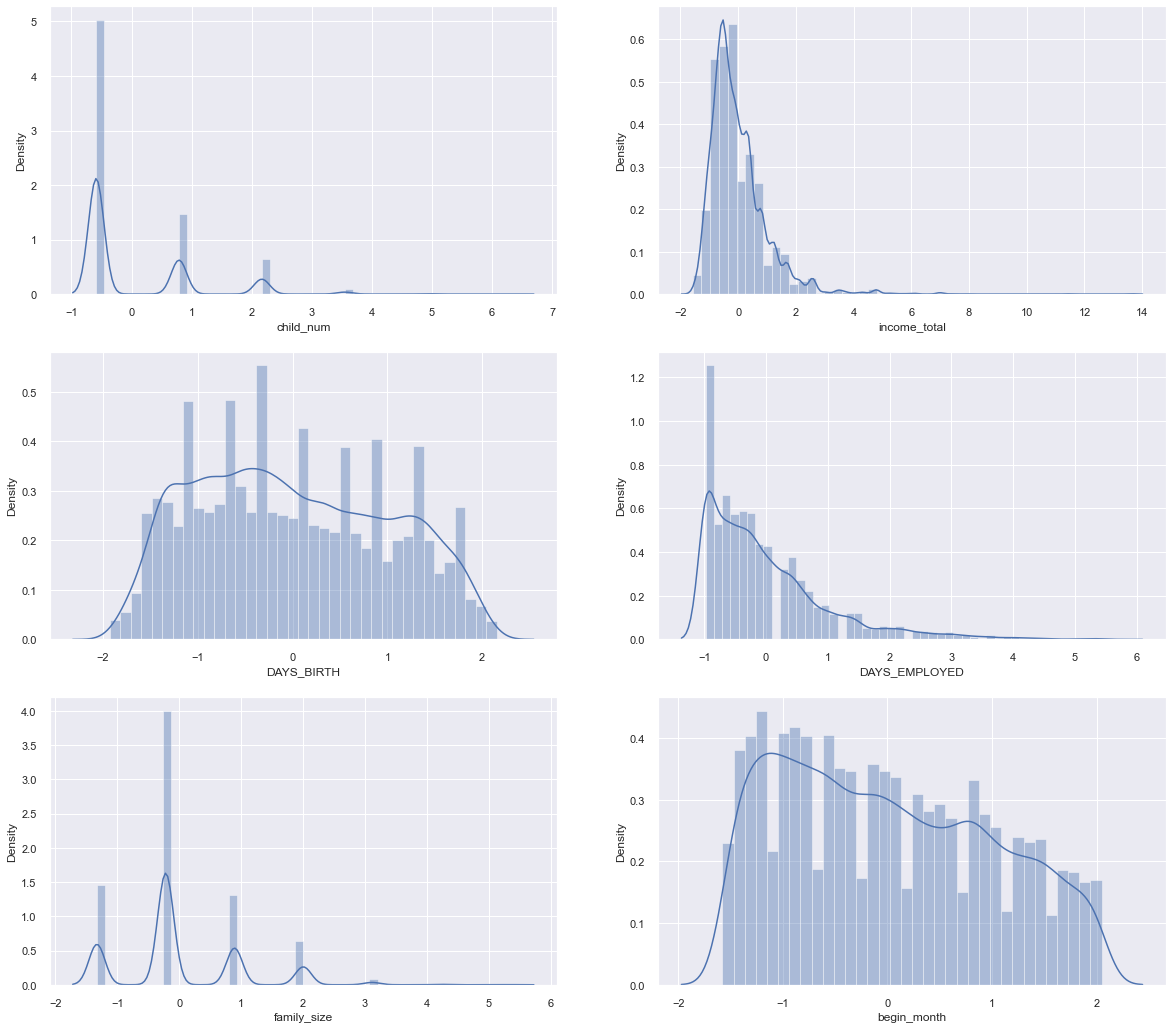

In [117]:
# MaxAbsScaler_data 적용한 후 분포도 확인
fig, ax = plt.subplots(3, 2, figsize=(20,18))

sns.distplot(StandardScaler_data['child_num'], ax=ax[0][0])
sns.distplot(StandardScaler_data['income_total'], ax=ax[0][1])

sns.distplot(StandardScaler_data['DAYS_BIRTH'], ax=ax[1][0])
sns.distplot(StandardScaler_data['DAYS_EMPLOYED'], ax=ax[1][1])

sns.distplot(StandardScaler_data['family_size'], ax=ax[2][0])
sns.distplot(StandardScaler_data['begin_month'], ax=ax[2][1])

#### 4-2-4 RobustScaler

In [118]:
from sklearn.preprocessing import RobustScaler

RobustScaler_data = train[train.columns.difference(['credit'])].copy()

robustScaler = RobustScaler()
print(robustScaler.fit(RobustScaler_data))
train_data_robustScaled = robustScaler.transform(RobustScaler_data)

# StandardScaler_data - StandardScaler 적용한 데이터 프레임
index = 0
for col in RobustScaler_data.columns :
    RobustScaler_data[col] = train_data_robustScaled[:,index]
    index = index + 1
display(RobustScaler_data)

RobustScaler()


,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,begin_month,car_N,car_Y,child_num,edu_type_Academic degree,edu_type_Higher education,edu_type_Incomplete higher,...,occyp_type_Realty agents,occyp_type_Sales staff,occyp_type_Secretaries,occyp_type_Security staff,occyp_type_Waiters/barmen staff,occyp_type_unfilled,phone,reality_N,reality_Y,work_phone
0,-0.210526,1.142857,0.0,-0.666667,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,-1.0,0.0
1,-0.578947,0.000000,0.0,-0.703704,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.526316,1.142857,0.0,-0.074074,-1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,-0.052632,0.142857,0.0,0.481481,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,-0.052632,0.142857,0.0,0.074074,-1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,-0.473684,0.142857,0.0,-0.814815,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0
26453,-0.052632,0.285714,0.0,0.851852,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
26454,-0.789474,0.142857,0.0,0.037037,-1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0
26455,-0.789474,-0.571429,0.0,1.296296,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<AxesSubplot:xlabel='begin_month', ylabel='Density'>

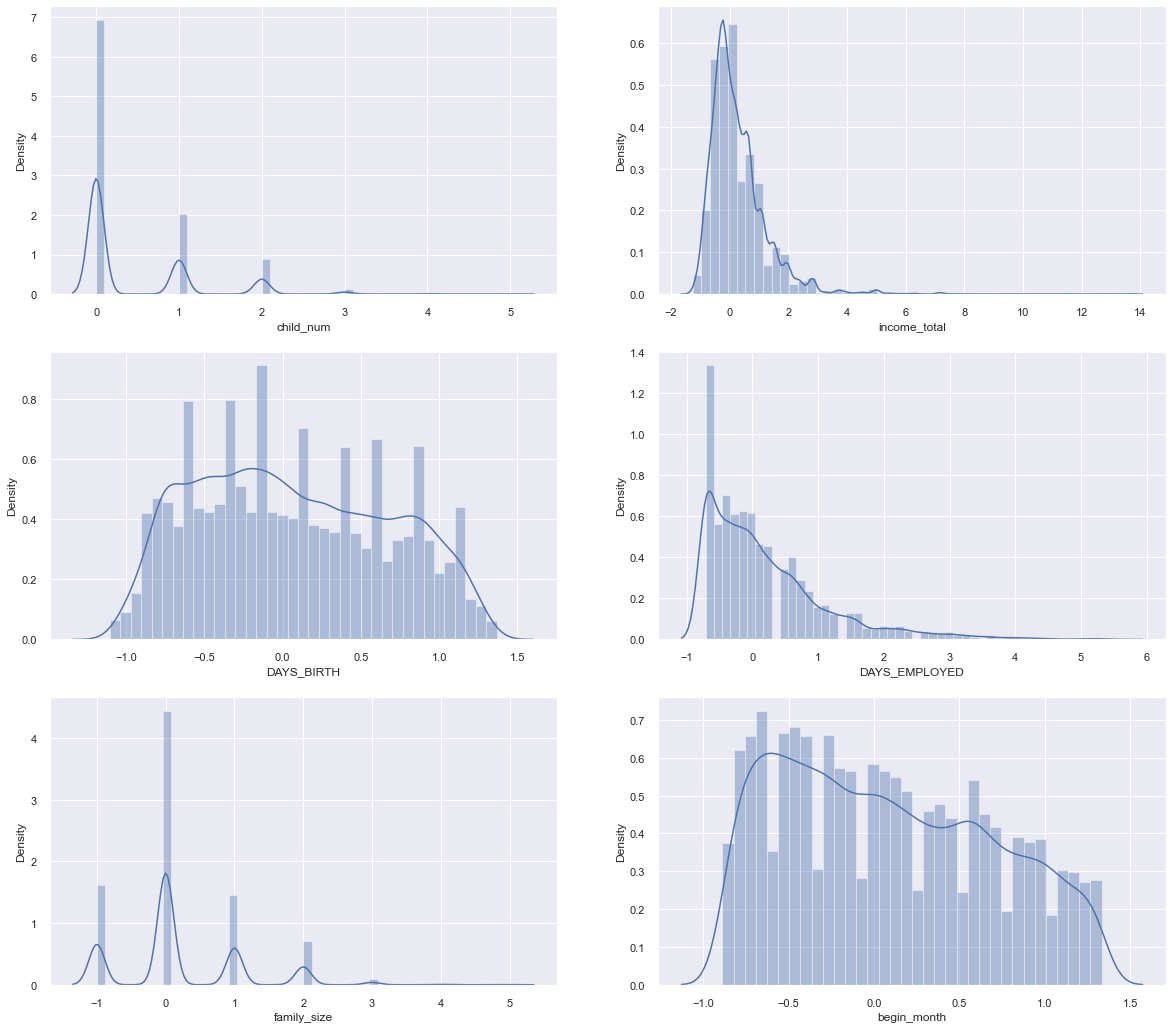

In [119]:
# MaxAbsScaler_data 적용한 후 분포도 확인
fig, ax = plt.subplots(3, 2, figsize=(20,18))

sns.distplot(RobustScaler_data['child_num'], ax=ax[0][0])
sns.distplot(RobustScaler_data['income_total'], ax=ax[0][1])

sns.distplot(RobustScaler_data['DAYS_BIRTH'], ax=ax[1][0])
sns.distplot(RobustScaler_data['DAYS_EMPLOYED'], ax=ax[1][1])

sns.distplot(RobustScaler_data['family_size'], ax=ax[2][0])
sns.distplot(RobustScaler_data['begin_month'], ax=ax[2][1])

In [120]:
# test.csv 정규화
from sklearn import preprocessing
testSet =  test.copy()
testSet = preprocessing.MinMaxScaler().fit(testSet).transform(testSet)

-----------------------------------------------
## 여기까지 정규화, 이상치 처리 완료해야 함, 데이터 전처리 단계

#### 정규화한 데이터 이름
* MinMaxScaler_data
* MaxAbsScaler_data
* StandardScaler_data
* RobustScaler_data

## 5. 모델링

### 5-0 데이터 분리
* 데이터 분리는 stratifiedKFold를 사용하여 y값 분포를 비슷하게 분리 시킴 -> 5-fold
    * StratifiedKFold(계층별 k-겹 교차검증) - 불균형한 분포도를 가진 레이블 데이터를 위한 방식, 특정 레이블 값이 너무 많거나 적은 경우
    * 타겟에 속성값의 개수를 동일하게 가져감으로써 kfold 같이 데이터가 한곳으로 몰리는 것을 방지
    * 대부분의 경우 회귀에서는 k-겹 교차 검증, 분류에서는 계층별 k-겹 교차검증의 기본값이 잘 작동함
* n_split는 몇 개로 분할할지 결정
* shtffle은 데이터 섞어서 샘플의 순서 랜덤하게. 
* 데이터를 섞을 때 random_state를 고정해서 똑같은 작업을 재현할 수있음
* 그렇지 않으면 cross_val_score를 실행할 때마다 폴드가 바뀌어 매번 결과가 달라짐

In [121]:
# 설명변수 X, 예측변수 y 할당 (사용하고자하는 정규화 스케일러로 변경 가능)
X = MinMaxScaler_data
Y = train['credit']

In [122]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) 
folds=[]

# 계층별 k-겹 교차검증을 위해 인덱스를 나누는 코드
for train_index, valid_index in skf.split(X, Y):
    folds.append((train_index, valid_index))
display(folds)

[(array([    0,     1,     3, ..., 26453, 26454, 26456]),
  array([    2,    26,    45, ..., 26446, 26452, 26455])),
 (array([    2,     3,     6, ..., 26454, 26455, 26456]),
  array([    0,     1,     4, ..., 26435, 26447, 26450])),
 (array([    0,     1,     2, ..., 26453, 26454, 26455]),
  array([    3,    12,    16, ..., 26438, 26448, 26456])),
 (array([    0,     1,     2, ..., 26454, 26455, 26456]),
  array([    6,    14,    29, ..., 26440, 26442, 26453])),
 (array([    0,     1,     2, ..., 26453, 26455, 26456]),
  array([    7,     9,    10, ..., 26449, 26451, 26454]))]

* 여기서 앞으로 계속 사용할 X,Y, folds 저장되어 있음

### 5-1. LGBM
[LGBM 모델 설명](https://lsjsj92.tistory.com/548)
#### Training    
* LGBM의 기본 파라미터로 훈련
* 30번 이상 개선 없을 경우 중단.
* 각 5개의 fold를 훈련하여 저장

In [123]:
random.seed(42)
lgb_models={}
for fold in range(5):
    print(f'===================================={fold+1}============================================')
    
    # 인덱스를 활용하여 train과 test 셋으로 분할
    train_index, valid_index = folds[fold]
    X_train, X_valid, Y_train, Y_valid = X.iloc[train_index].values, X.iloc[valid_index].values,\
                                         Y[train_index].values, Y[valid_index].values 
    
    # LGBM 모델 돌리기, 
    # 30번 이상 개선 없을 시 중단, 5개의 fold를 훈련하여 저장
    lgb = LGBMClassifier(n_estimators=1000)
    lgb.fit(X_train, Y_train, 
            eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
            early_stopping_rounds=30,
           verbose=100)
    lgb_models[fold]=lgb
    print(f'================================================================================\n\n')

====================================1============================================
Training until validation scores don't improve for 30 rounds
[100]	training's multi_logloss: 0.661572	valid_1's multi_logloss: 0.757333
[200]	training's multi_logloss: 0.58197	valid_1's multi_logloss: 0.746667
[300]	training's multi_logloss: 0.52123	valid_1's multi_logloss: 0.740976
Early stopping, best iteration is:
[344]	training's multi_logloss: 0.4976	valid_1's multi_logloss: 0.739465


====================================2============================================
Training until validation scores don't improve for 30 rounds
[100]	training's multi_logloss: 0.658231	valid_1's multi_logloss: 0.767834
[200]	training's multi_logloss: 0.576896	valid_1's multi_logloss: 0.757428
Early stopping, best iteration is:
[247]	training's multi_logloss: 0.546133	valid_1's multi_logloss: 0.754792


====================================3============================================
Training until validation scores don'

#### Test inference
* 각 폴드를 훈련시킨 LGBM으로 예측
* 해당 대회는 logloss score를 겨루는 것이기 때문에 각 class의 probability를 얻어야함
* 대부분의 머신러닝 모델에서 predict, predict_proba를 구분하여 사용함.
* predict는 class 출력을 해주고 predict_proba는 class 별 probability를 출력해줌
* predict_proba를 사용하여 예측한 것을 5-fold 더하여 평균내어 앙상블함

In [126]:
submit.iloc[:,1:]=0
for fold in range(5):
    submit.iloc[:,1:] += lgb_models[fold].predict_proba(testSet)/5

In [127]:
submit.to_csv('./LGBM_test_0422.csv', index=False) # 0.7272812144

In [128]:
submit.head(20)

,index,0,1,2
0,26457,0.345367,0.653340,0.001294
1,26458,0.008147,0.041828,0.950025
2,26459,0.116127,0.882961,0.000912
3,26460,0.019372,0.114032,0.866596
4,26461,0.005318,0.113835,0.880847
5,26462,0.442002,0.358422,0.199576
6,26463,0.005364,0.124933,0.869703
7,26464,0.065467,0.933607,0.000927
8,26465,0.361034,0.116307,0.522659
9,26466,0.314975,0.288772,0.396254


In [129]:
display(X)
display(Y)

,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,begin_month,car_N,car_Y,child_num,edu_type_Academic degree,edu_type_Higher education,edu_type_Incomplete higher,...,occyp_type_Realty agents,occyp_type_Sales staff,occyp_type_Secretaries,occyp_type_Security staff,occyp_type_Waiters/barmen staff,occyp_type_unfilled,phone,reality_N,reality_Y,work_phone
0,0.361702,0.295455,0.0,0.100000,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.212766,0.113636,0.0,0.083333,1.0,0.0,0.2,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.659574,0.295455,0.0,0.366667,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.425532,0.136364,0.0,0.616667,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,0.425532,0.136364,0.0,0.433333,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,0.255319,0.136364,0.0,0.033333,1.0,0.0,0.4,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
26453,0.425532,0.159091,0.0,0.783333,1.0,0.0,0.2,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
26454,0.127660,0.136364,0.0,0.416667,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
26455,0.127660,0.022727,0.0,0.983333,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


0        1.0
1        1.0
2        2.0
3        0.0
4        2.0
        ... 
26452    1.0
26453    2.0
26454    2.0
26455    2.0
26456    2.0
Name: credit, Length: 26457, dtype: float64

### 5-2. **로지스틱 회귀분석**

In [130]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

random.seed(42)
logR_models={}
for fold in range(5):
    print(f'===================================={fold+1}============================================')
    
    # 인덱스를 활용하여 train과 test 셋으로 분할
    train_index, valid_index = folds[fold]
    X_train, X_valid, Y_train, Y_valid = X.iloc[train_index].values, X.iloc[valid_index].values,\
                                         Y[train_index].values, Y[valid_index].values 
    
    # 로지스틱 회귀
    logmodel = LogisticRegression()
    logmodel.fit(X_train, Y_train)
    print(f'Log Loss: {log_loss(Y_valid, logmodel.predict_proba(X_valid)):.6f}')
    logR_models[fold]=logmodel
    print('학습용 데이터셋 정확도 : %.5f' % logmodel.score(X_train, Y_train))
    print('검증용 데이터셋 정확도 : %.5f' % logmodel.score(X_valid, Y_valid))
#     print('컬럼의 계수 확인 : ', logmodel.coef_)
    print(f'================================================================================\n\n')

====================================1============================================
Log Loss: 0.866987
학습용 데이터셋 정확도 : 0.64352
검증용 데이터셋 정확도 : 0.64324
컬럼의 계수 확인 :  [[-5.91977782e-02  4.37200229e-02  0.00000000e+00 -1.23756171e-01
  -1.21394310e-01 -1.06244179e-01 -2.71834973e-02 -2.47644078e-01
   2.77241454e-02 -4.40361052e-02 -6.51194416e-03  4.28294930e-02
  -8.29111527e-02 -7.61465002e-02  2.78042350e-02 -1.14355489e-02
  -4.27344274e-03 -7.46350586e-02 -1.65098674e-01 -9.92088663e-02
  -1.28429623e-01 -4.73430583e-02  2.28446002e-03  4.70963069e-02
  -6.62074066e-02 -1.29692639e-01 -3.37761519e-02  5.53512438e-01
  -1.50895539e-02  1.32966925e-02 -6.10019143e-03 -1.59555762e-01
  -6.01896741e-02 -6.70130533e-02 -1.84221119e-01 -1.70988171e-02
  -4.19432851e-03 -2.47298088e-02  2.93993196e-01 -1.28504123e-01
   4.59833199e-01 -2.20474037e-02  3.36904811e-01  3.36999449e-03
  -3.07478680e-01  1.00038423e-01  3.67844572e-01 -1.49994858e-01
  -1.62997293e-01 -1.90420181e-01 -4.19856274e-0

In [ ]:
# from sklearn.metrics import classification_report
# y_pred=log.predict(X_test)
# print(classification_report(y_test, y_pred))

# 아래 결과는 md파일 참고
# print(log.predict_proba(test))

In [132]:
# csv 파일 생성
submit.iloc[:,1:]=0
for fold in range(5):
    submit.iloc[:,1:] += logR_models[fold].predict_proba(testSet)/5

submit.to_csv('./logR_0422.csv', index=False)

### 5-3 KNN

In [ ]:
# 설명변수 X, 예측변수 y 할당
X = train[train.columns.difference(['credit'])]
y = train['credit']

In [ ]:
# 설명변수 정규화
from sklearn import preprocessing
X = preprocessing.MinMaxScaler().fit(X).transform(X)

In [ ]:
# 훈련, 검증 데이터를 7:3 비율로 구분
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [ ]:
# 최적 k 도출 - Cross Validation 이용
# 시간 진 ~ 짜 오래걸리니까 ... 변한거 없으면 그냥 돌리지 마세요 ....!
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

k_range = range(1,50) # 1~100 에서 최적 k 찾기
k_scores = []

for k in k_range :
    print(k)
    knn = KNeighborsClassifier(k)
    scores = cross_val_score(knn, X, y, cv=10, scoring = "accuracy") # 10-fold cross validation
    k_scores.append(scores.mean())
    

In [ ]:
# 최적 k를 그래프로 확인    
plt.plot(k_range, k_scores)
plt.xlabel('value of K for KNN')
plt.ylabel('Cross_Validation Accuracy')
plt.show()

# k_scores 리스트에서 최댓값의 index 구하기 (최적 k 찾기)
k = k_scores.index(max(k_scores)) + 1
print(k)

In [ ]:
# 최적 k로 모델 학습
# sklearn 라이브러리에서 KNN 분류 모형 가져오기
from sklearn.neighbors import KNeighborsClassifier

# 모형 객체 생성 (최적 k 사용)
knn = KNeighborsClassifier(n_neighbors=75) # 75로 해놓음

# train data를 가지고 모형 학습
knn.fit(X_train, y_train)

# test data를 가지고 예측(분류)하고 예측값을 y_hat에 저장
y_hat = knn.predict(X_test)

# 시각적으로 확인해보기
print(y_hat[0:10])
print(y_test.values[0:10])

In [ ]:
# 모형 성능 평가 - confusion Matrix 계산
from sklearn import metrics
knn_matrix = metrics.confusion_matrix(y_test, y_hat)
print(knn_matrix)

In [ ]:
# 모형 성능 평가 - 평가 지표 계산
knn_report = metrics.classification_report(y_test, y_hat)
print(knn_report)

### 5-4. SVM

In [ ]:
from sklearn.model_selection import train_test_split

# 설명변수 X, 예측변수 y 할당
X = train[train.columns.difference(['credit'])]
y = train['credit']

# 설명변수 정규화
from sklearn import preprocessing
X = preprocessing.MinMaxScaler().fit(X).transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [ ]:
from sklearn import svm

# 모형 객체 생성 (kernel='rbf' 적용)
svm_model = svm.SVC(kernel='rbf', probability=True)

# train data를 가지고 모형 학습
svm_model.fit(X_train, y_train)   

# test data를 가지고 y_hat을 예측 (분류) 
y_hat = svm_model.predict(X_test)

print(y_hat[0:10])
print(y_test[0:10])

In [ ]:
# 모형 성능 평가 - Confusion Matrix 계산
from sklearn import metrics 
svm_matrix = metrics.confusion_matrix(y_test, y_hat)  
print(svm_matrix)
print('\n')

# 모형 성능 평가 - 평가지표 계산
svm_report = metrics.classification_report(y_test, y_hat)            
print(svm_report)

In [ ]:
# csv 파일 생성
submit.iloc[:,1:]=0
submit.iloc[:,1:] =log.predict_proba(test)

submit.to_csv('./20210422_test_submit_svm.csv', index=False)

* logloss

In [ ]:
print(svm_model.predict_proba(X_test))

In [ ]:
from sklearn.metrics import log_loss
print(log_loss(y_test, svm_model.predict_proba(X_test)))